In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

## First of all for  creating a good prediction model  we should find highest correlations between features (made sure features are not causing memory leakage)

['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']
Exam_Score           1.000000
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours         -0.017022
Name: Exam_Score, dtype: float64


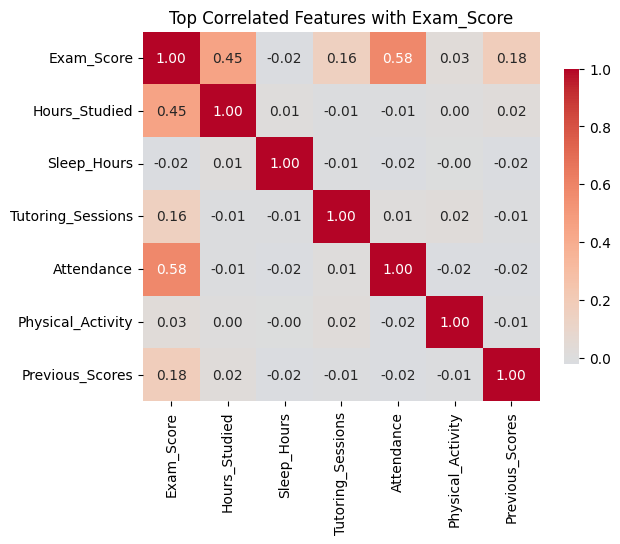

Correlation between Parental_Involvement and Exam_Score: 0.157


In [3]:
# Load data
df = pd.read_csv('StudentPerformanceFactors.csv')

# Define color palette
palette = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#f1c40f'}
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(numeric_cols)

# Calculate correlation with 'Exam_Score'
correlations = df[numeric_cols].corr()['Exam_Score'].sort_values(ascending=False)
print(correlations)

# Get the top 6 correlated features with Exam_Score
top_corrs = correlations.abs().sort_values(ascending=False).head(9).index.tolist()

# Ensure 'Exam_Score' is included
top_corrs = list(set(top_corrs + ['Exam_Score']))

# Plot the heatmap of correlations
sns.heatmap(df[top_corrs].corr(), annot=True, cmap='coolwarm', fmt=".2f", center=0, cbar_kws={'shrink': .8})
plt.title("Top Correlated Features with Exam_Score")
plt.show()

# Map categorical levels to numeric scale
involvement_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['Parental_Involvement_Encoded'] = df['Parental_Involvement'].map(involvement_mapping)

# Now calculate correlation with Exam_Score
correlation = df[['Parental_Involvement_Encoded', 'Exam_Score']].corr().iloc[0, 1]
print(f"Correlation between Parental_Involvement and Exam_Score: {correlation:.3f}")

1. Attendance (0.58)
Strongest positive correlation.
- Students who attend more tend to perform better.

2. Hours_Studied (0.45)
Consistently important across visualizations.
- More study time is linked to higher scores.

3. Tutoring_Sessions (0.16)
Moderate effect.
- Extra help appears to slightly improve results.

4.  Previous_Scores (0.18)
Prior performance has some influence, but less than attendance or study habits.

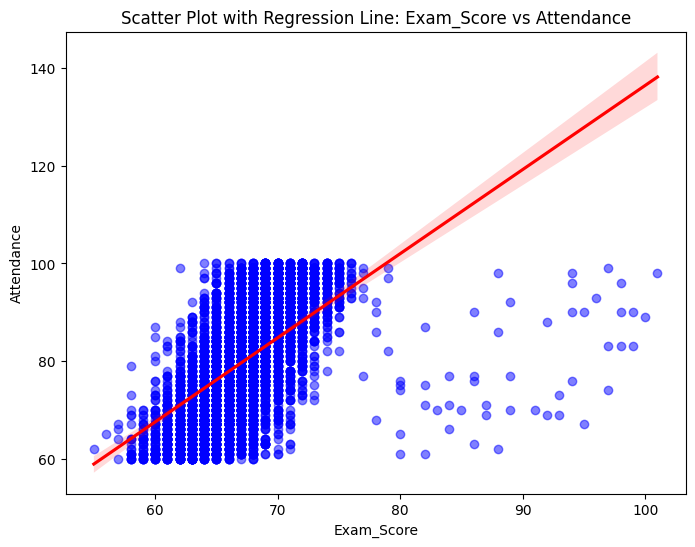

In [4]:

# Set the figure size
plt.figure(figsize=(8,6))

# Create scatter plot with a regression line
sns.regplot(x='Exam_Score', y='Attendance', data=df, scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})

# Label the axes
plt.xlabel('Exam_Score')
plt.ylabel('Attendance')

# Title of the plot
plt.title('Scatter Plot with Regression Line: Exam_Score vs Attendance')

# Show the plot
plt.show()

1. Strong Positive Correlation
As exam scores increase, attendance levels also tend to increase.
This reinforces earlier findings: students who attend more tend to score higher.

2. Dense Block Around Score 60–75
Most students have exam scores between 60–75, with attendance clustered between 70–100.
Suggests a stable group of average-performing, regularly attending students.

3. Fewer Outliers at High Scores
Very few students have high scores (>90) with low attendance — most of them also have high attendance.

The plot confirms a clear linear relationship between academic performance and attendance.
Attendance increases as exam scores increase, highlighting attendance as a key driver of success in this dataset.



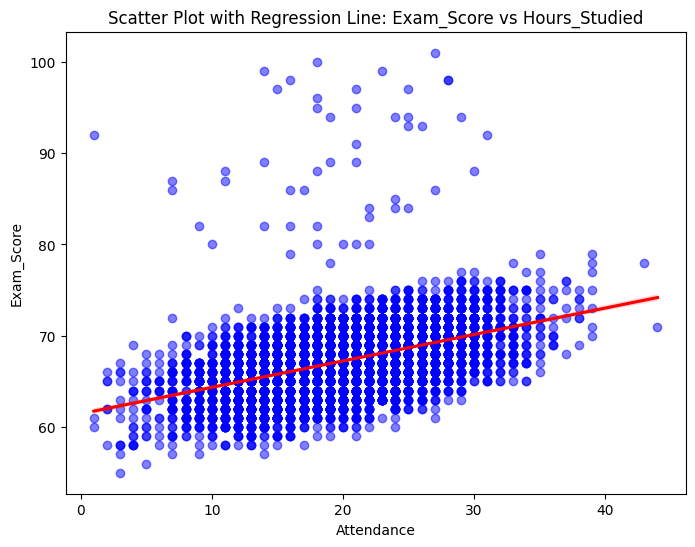

In [5]:

# Set the figure size
plt.figure(figsize=(8,6))

# Create scatter plot with a regression line
sns.regplot(x='Hours_Studied', y='Exam_Score', data=df, scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})

# Label the axes
plt.ylabel('Exam_Score')
plt.xlabel('Attendance')

# Title of the plot
plt.title('Scatter Plot with Regression Line: Exam_Score vs Hours_Studied')

# Show the plot
plt.show()

1. Positive Correlation
The regression line slopes upward, meaning that as attendance increases, exam scores tend to increase.
This suggests that attendance is a good predictor of student performance.

2. Tight Clusters at Lower Scores
Most students are clustered between scores 60–75 and attendances 0–30.
A clear trend is visible even in this dense region.

3. High Performers with High Attendance
Students scoring above 90 generally have moderate to high attendance, supporting the correlation.

This plot confirms a moderate to strong positive relationship between attendance and exam performance.
Students with higher attendance are more likely to succeed — making this feature highly valuable for prediction models.

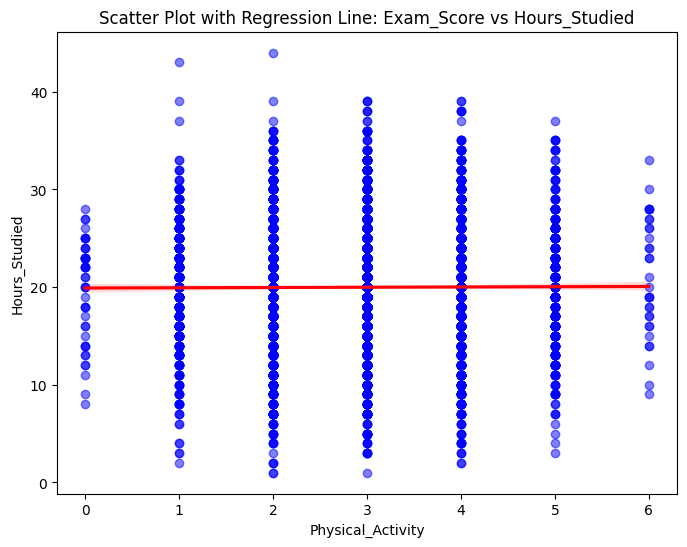

In [6]:

# Set the figure size
plt.figure(figsize=(8,6))

# Create scatter plot with a regression line
sns.regplot(x='Physical_Activity', y='Hours_Studied', data=df, scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})

# Label the axes
plt.xlabel('Physical_Activity')
plt.ylabel('Hours_Studied')

# Title of the plot
plt.title('Scatter Plot with Regression Line: Exam_Score vs Hours_Studied')

# Show the plot
plt.show()

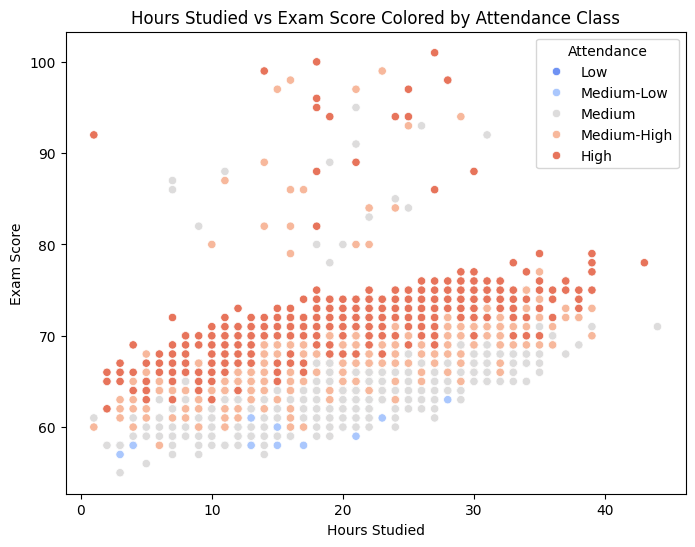

count    6607.000000
mean       79.977448
std        11.547475
min        60.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: Attendance, dtype: float64
(59.959, 64.0]    740
(64.0, 68.0]      663
(68.0, 72.0]      660
(72.0, 76.0]      667
(76.0, 80.0]      693
(80.0, 84.0]      673
(84.0, 88.0]      603
(88.0, 92.0]      647
(92.0, 96.0]      678
(96.0, 100.0]     583
Name: count, dtype: int64


In [7]:
# Convert Attendance to multiple classes: Low, Medium-Low, Medium, Medium-High, High
df['Attendance_class'] = pd.cut(df['Attendance'],
                                bins=[0, 40, 60, 70, 85, 100],
                                labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
                                include_lowest=True)

# Plot with Attendance_Class as hue
plt.figure(figsize=(8, 6))

# Scatterplot using Attendance_Class as hue
sns.scatterplot(x='Hours_Studied', y='Exam_Score', hue='Attendance_class', palette='coolwarm', data=df)

plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Hours Studied vs Exam Score Colored by Attendance Class')
plt.legend(title='Attendance')
plt.show()
print(df['Attendance'].describe())
print(df['Attendance'].value_counts(bins=10, sort=False))

There’s a clear correlation between study time, attendance, and exam performance.
Higher attendance is associated with better outcomes, reinforcing its importance in predicting success.

In [8]:
features = df[['Hours_Studied', 'Exam_Score']].values
labels = df['Attendance_class'].values


# Pick a random student
sample_index = np.random.randint(0, len(df))
sample_point = features[sample_index]
print("Sample Point (Hours Studied, Exam Score):", sample_point)

# Calculate distances from all other points
distances = []
for i, point in enumerate(features):
    dist = np.sqrt((sample_point[0] - point[0])**2 + (sample_point[1] - point[1])**2)
    distances.append((dist, labels[i]))

# Sort by distance
distances.sort(key=lambda x: x[0])


k = 10 # You can try different k values
nearest_labels = [label for _, label in distances[1:k+1]]  # skip index 0 (self)
label_counts = Counter(nearest_labels)

# Majority class
predicted_class = label_counts.most_common(1)[0][0]

print(f"Predicted Attendance : {predicted_class}")
print(f"Actual Attendance: {labels[sample_index]}")

Sample Point (Hours Studied, Exam Score): [15 63]
Predicted Attendance : Medium
Actual Attendance: Medium-High


In [9]:
import numpy as np
from collections import Counter
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Extract Features and Labels
features = df[['Hours_Studied', 'Exam_Score']].values
labels = df['Attendance_class'].values

# Initialize lists to store actual and predicted labels
predicted_labels = []
actual_labels = []

# Define the number of nearest neighbors
k = 10


# Iterate over all data points to predict their labels
for sample_index in range(len(df)):
    sample_point = features[sample_index]
    
    # Calculate distances from all other points
    distances = []
    for i, point in enumerate(features):
        dist = np.sqrt((sample_point[0] - point[0])**2 + (sample_point[1] - point[1])**2)
        distances.append((dist, labels[i]))
    
    # Sort distances and get the k nearest labels
    distances.sort(key=lambda x: x[0])
    nearest_labels = [label for _, label in distances[1:k+1]]  # skip index 0 (self)
    
    # Get majority class
    label_counts = Counter(nearest_labels)
    predicted_class = label_counts.most_common(1)[0][0]
    
    # Store the actual and predicted labels
    predicted_labels.append(predicted_class)
    actual_labels.append(labels[sample_index])

# Calculate accuracy, precision, recall
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='macro', labels=np.unique(labels))
recall = recall_score(actual_labels, predicted_labels, average='macro', labels=np.unique(labels))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6657
Precision: 0.5046
Recall: 0.5012


c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6658
Precision: 0.5015
Recall: 0.5043


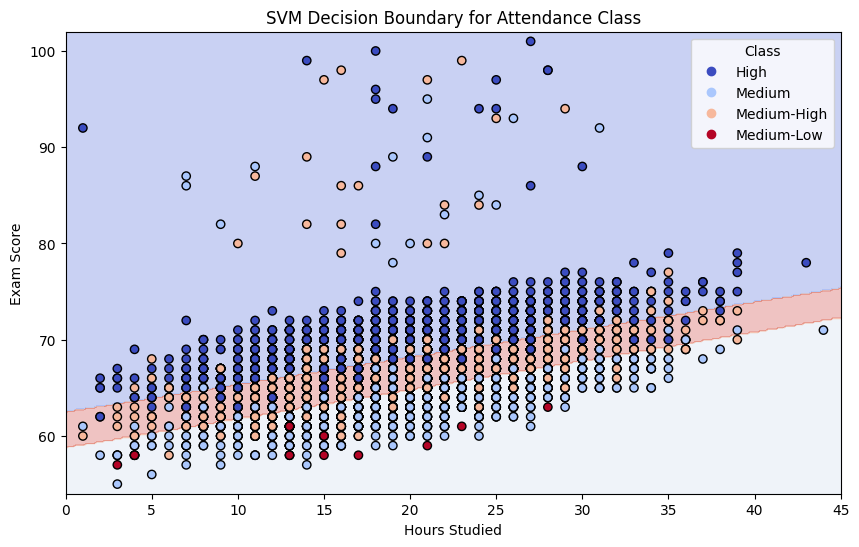

In [10]:
# Extract features and target
features = df[['Hours_Studied', 'Exam_Score']].values
labels = df['Attendance_class'].values

# Encode target labels if they are strings
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Train SVM
clf = SVC(kernel='linear') 
clf.fit(features, encoded_labels)

# Predict using the same data
predicted_labels = clf.predict(features)

# Metrics
accuracy = accuracy_score(encoded_labels, predicted_labels)
precision = precision_score(encoded_labels, predicted_labels, average='macro')
recall = recall_score(encoded_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Visualize decision boundary
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
scatter = plt.scatter(features[:, 0], features[:, 1], c=encoded_labels, cmap='coolwarm', edgecolor='k')
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("SVM Decision Boundary for Attendance Class")
handles, _ = scatter.legend_elements()
class_labels = [f"{label}" for label in le.classes_]
plt.legend(handles=handles, labels=class_labels, title="Class")
plt.show()

1. Linear separation boundary
The SVM learned a mostly linear margin separating the classes — expected for SVMs with a linear kernel.

2. Classes overlap significantly
Many different attendance classes share similar study hours and exam scores, which causes visible misclassification in overlapping regions (especially medium levels).

3. Dense pass cluster (top-right)
The upper right of the plot (high hours studied + high exam score) is heavily populated by High attendance students, which aligns with expectations.

4. Precision and recall are modest
Precision: 0.5015, Recall: 0.5043
Indicates the SVM had difficulty clearly distinguishing classes, likely due to feature overlap or label imbalance.

In [11]:
print(df.columns)

Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score', 'Parental_Involvement_Encoded', 'Attendance_class'],
      dtype='object')


c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6681
Precision: 0.5063
Recall: 0.5037


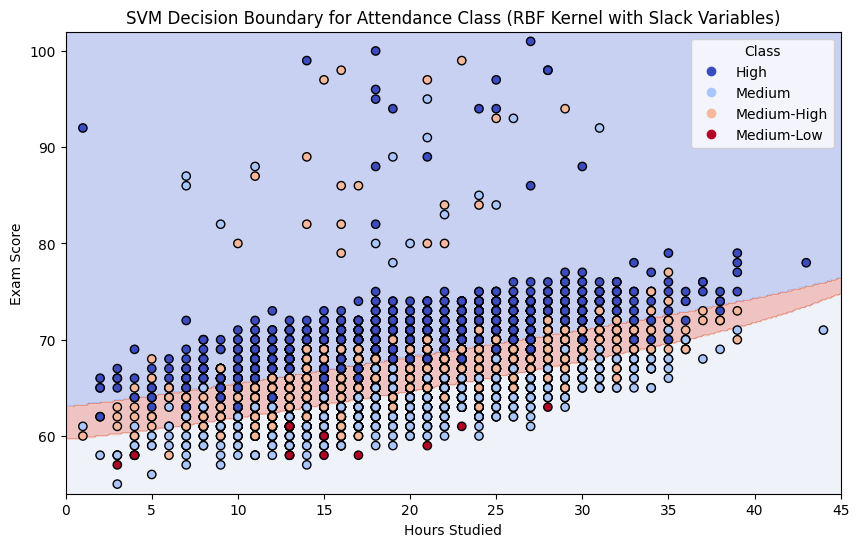

In [12]:

# Assuming 'df' is already loaded and 'Attendance_class' is created from the previous code

# Extract features and target
features = df[['Hours_Studied', 'Exam_Score']].values
labels = df['Attendance_class'].values

# Encode target labels if they are strings
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Train SVM with RBF kernel and regularization parameter C (for slack variables)
# You can adjust the value of C
clf = SVC(kernel='rbf', C=1.0)
clf.fit(features, encoded_labels)

# Predict using the same data
predicted_labels = clf.predict(features)

# Metrics
accuracy = accuracy_score(encoded_labels, predicted_labels)
precision = precision_score(encoded_labels, predicted_labels, average='macro')
recall = recall_score(encoded_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Visualize decision boundary
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
scatter = plt.scatter(features[:, 0], features[:, 1], c=encoded_labels, cmap='coolwarm', edgecolor='k')
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("SVM Decision Boundary for Attendance Class (RBF Kernel with Slack Variables)")
handles, _ = scatter.legend_elements()
class_labels = [f"{label}" for label in le.classes_]
plt.legend(handles=handles, labels=class_labels, title="Class")
plt.show()

### Decision Tree Regressor


In [13]:
# data load 
df = pd.read_csv('StudentPerformanceFactors.csv')

# label encoding catgorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


X = df[['Attendance', 'Hours_Studied', 'Previous_Scores', 'Motivation_Level']] #features variables
y = df['Exam_Score'] # target variable

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Regressor and fit model
reg = DecisionTreeRegressor(max_depth=4, random_state=42)
reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MSE: 6.683179643956712
R² Score: 0.5271916959254247


### Plot Tree

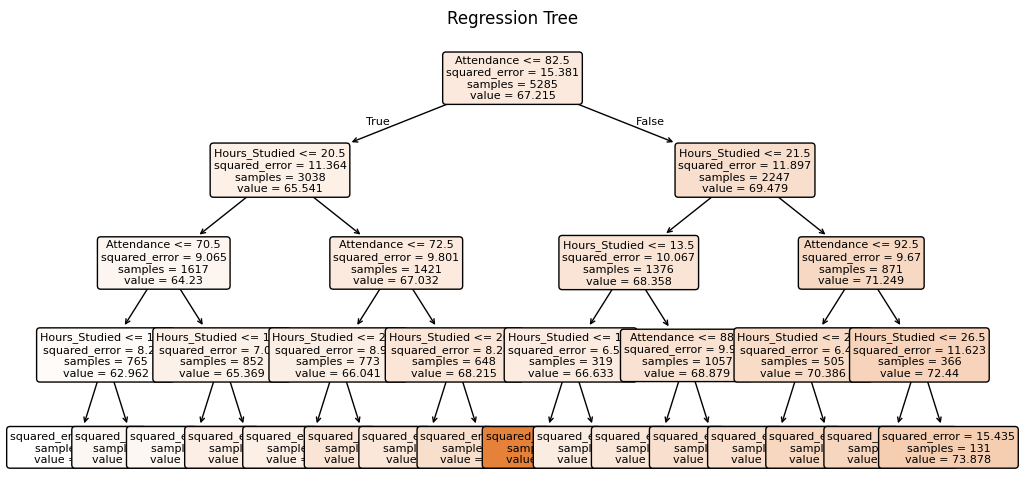

In [14]:
# plotting the decision tree
plt.figure(figsize=(12, 6))
plot_tree(reg, feature_names=['Attendance', 'Hours_Studied', 'Previous_Scores', 'Motivation_Level'], filled=True, rounded=True, fontsize=8)
plt.title('Regression Tree')
plt.show()

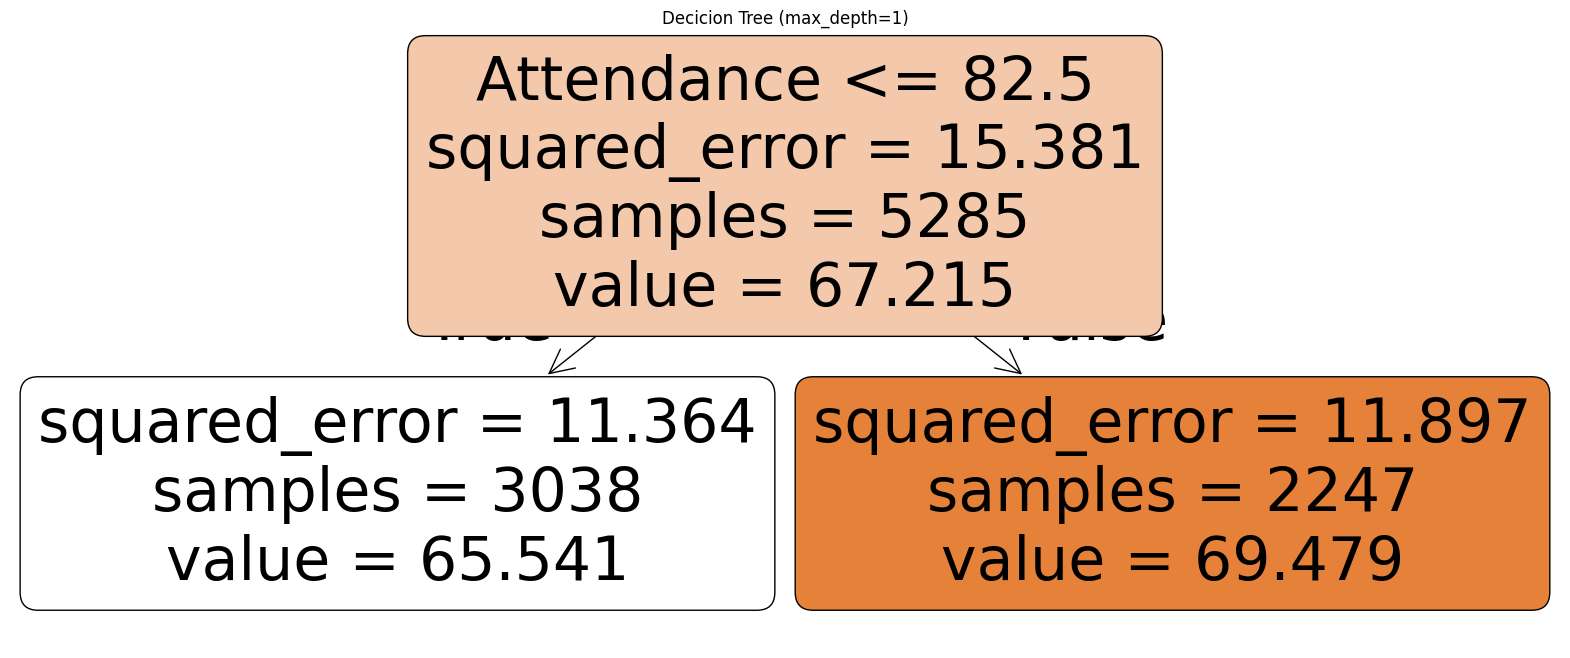

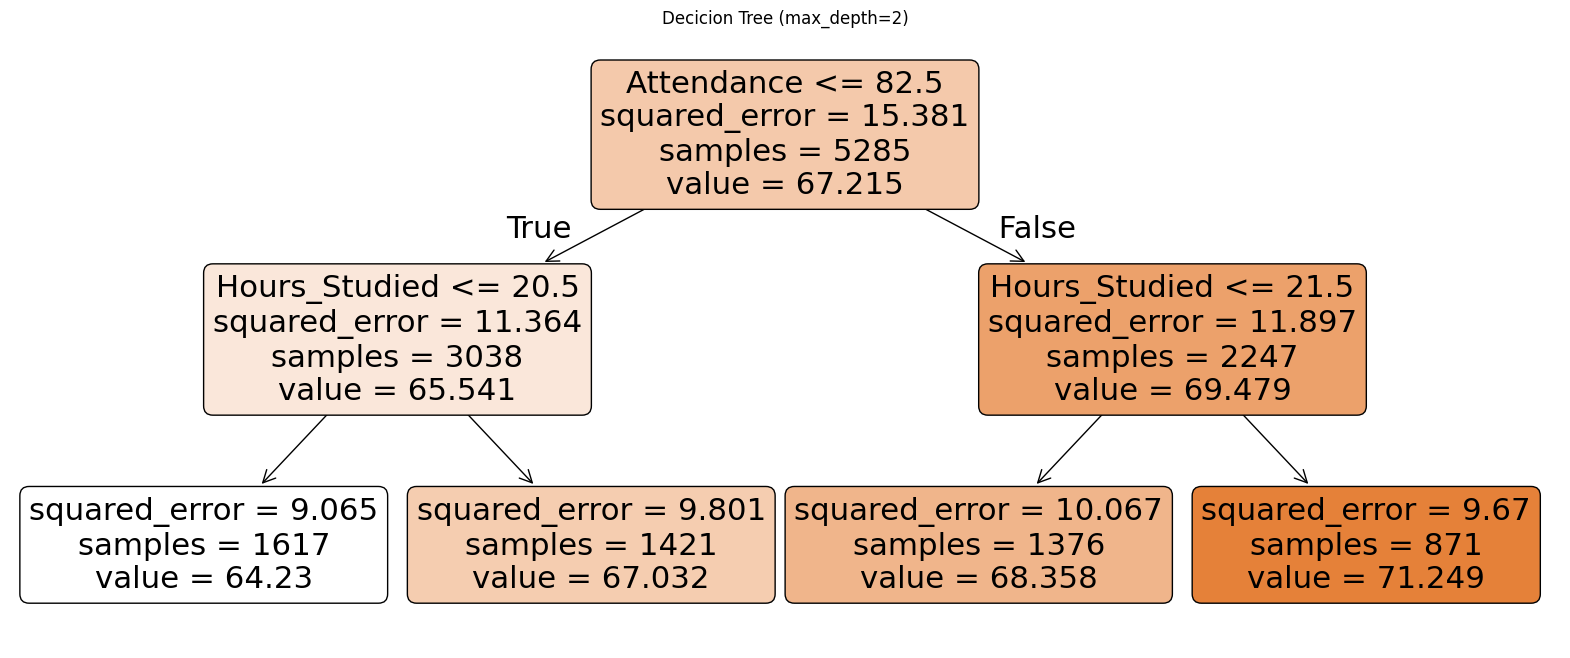

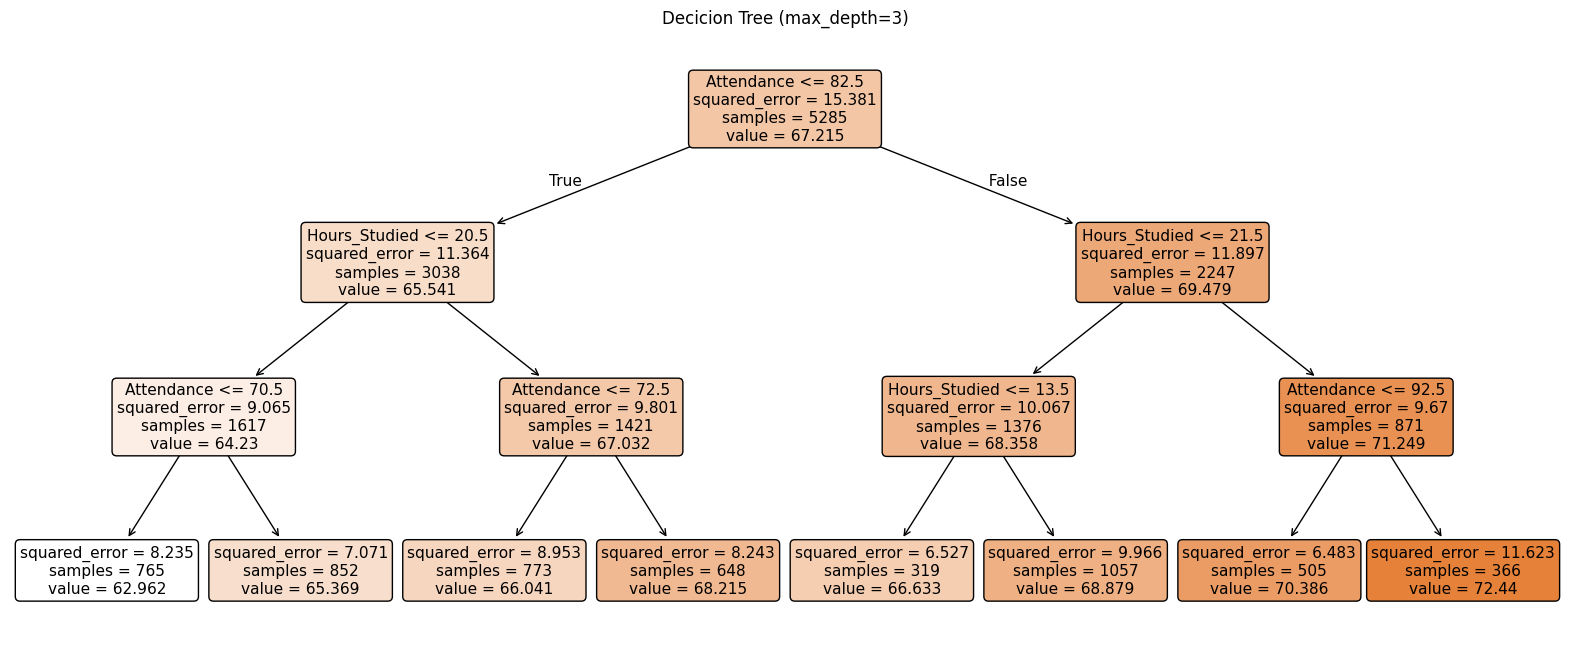

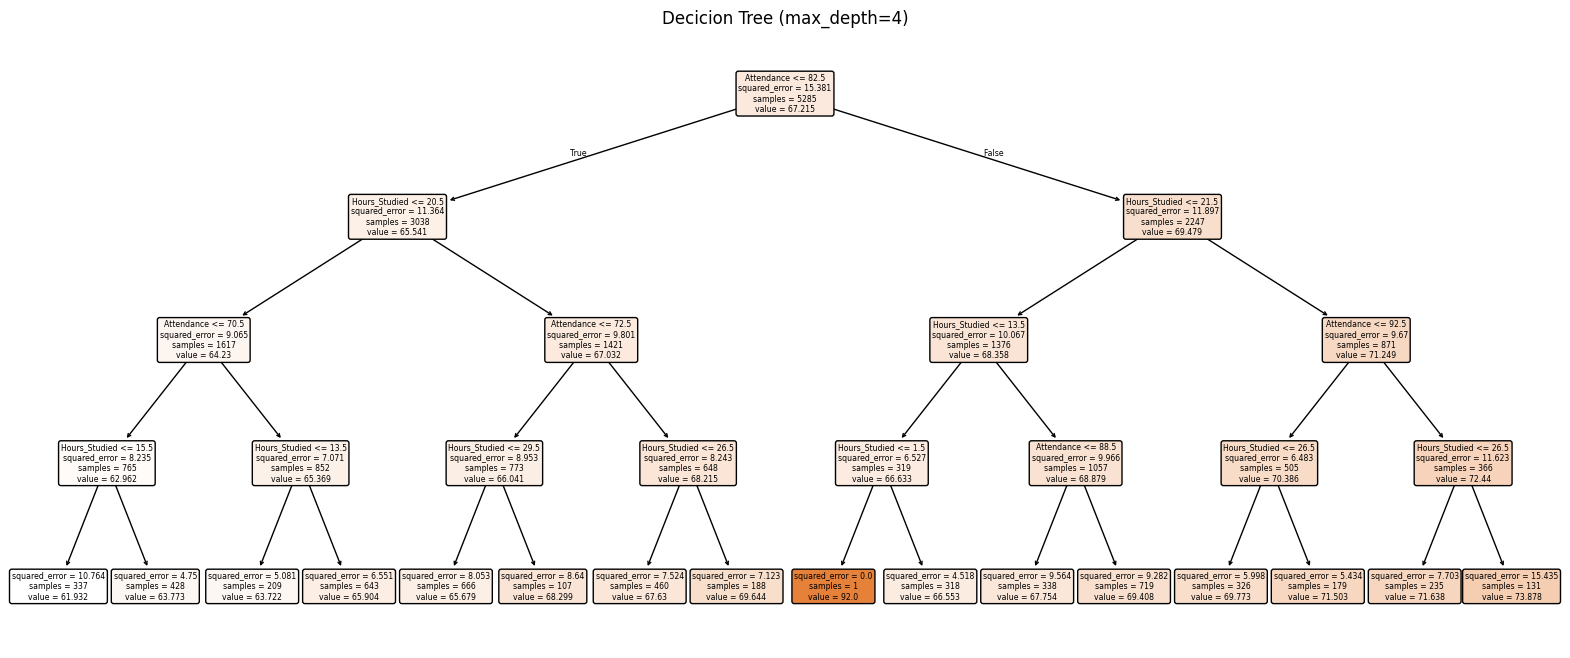

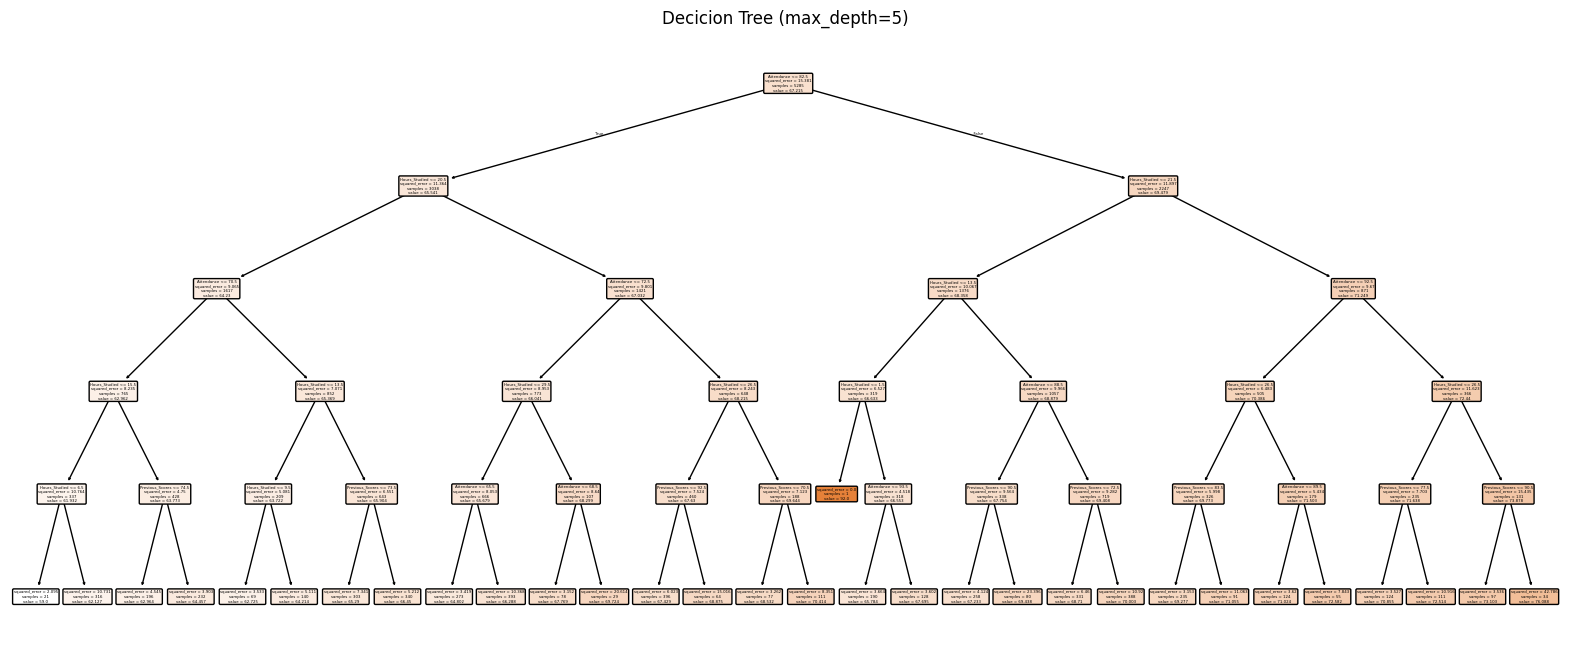

In [15]:
# plotting the decision tree fot different max_depth values
depths = [1, 2, 3, 4, 5]

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    plt.figure(figsize=(20, 8))
    plot_tree(model, feature_names=X.columns, filled=True, rounded=True, max_depth=depth)
    plt.title(f'Decicion Tree (max_depth={depth})')
    plt.show()

### Decision Tree Classifier

In [16]:
# Target: binary class based on Exam Score
df['Result'] = df['Exam_Score'].apply(lambda x: 1 if x >= 60 else 0)

# label encoding categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[['Attendance', 'Hours_Studied', 'Previous_Scores', 'Motivation_Level']] # features variables
y = df['Result'] # target variable

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9909228441754917
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.18      0.25        11
           1       0.99      1.00      1.00      1311

    accuracy                           0.99      1322
   macro avg       0.70      0.59      0.62      1322
weighted avg       0.99      0.99      0.99      1322



### Gini Root Impurity

In [17]:
# function to compute Gini impurity for a given subset of data
def compute_gini(subset):
    class_probs = subset['Result'].value_counts(normalize=True) # get class probabilities
    return round(1 - sum(class_probs ** 2), 4) # apply Gini formula: 1 - Σ(p_i²)


root_gini = compute_gini(df)
print(root_gini)
print(df['Result'].value_counts(normalize=True).round(3))

0.0204
Result
1    0.99
0    0.01
Name: proportion, dtype: float64


In [18]:
# split the dataset based on Attendance threshold = 70
left_split = df[df['Attendance'] < 70]
right_split = df[df['Attendance'] >= 70]

# compute Gini impurity for each split
left_gini = compute_gini(left_split)
right_gini = compute_gini(right_split)

print('Gini of left = ', left_gini, 'of samples:', len(left_split))
print('Gini of right = ', right_gini,  'of samples:', len(right_split))

Gini of left =  0.0769 of samples: 1573
Gini of right =  0.002 of samples: 5034


In [19]:
total = len(df) # total number of samples
n_left = len(left_split) # number of samples in left split
n_right = len(right_split) # number of samples in right split

p_left = n_left / total # proportion of samples in left split
p_right = n_right / total # proportion of samples in right split

weighted_gini = round(p_left * left_gini + p_right * right_gini, 4) # weighted Gini impurity

root_gini = compute_gini(df)  # compute Gini impurity for the root node
gini_reduction = round(root_gini - weighted_gini, 4) # # Gini reduction

print("Weighted Gini =", weighted_gini)
print("Root Gini =", root_gini)
print("Gini Reduction =", gini_reduction)

Weighted Gini = 0.0198
Root Gini = 0.0204
Gini Reduction = 0.0006


In [20]:
# Target: binary class based on Exam Score
df['Result'] = df['Exam_Score'].apply(lambda x: 'Pass' if x >= 60 else 'Fail')

X_class = df[['Attendance', 'Hours_Studied', 'Previous_Scores', 'Motivation_Level']] # features variables
y_class = df['Result'] # target variable

# split into train and test sets
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(Xc_train, yc_train)

# Predict and evaluate
yc_pred = clf.predict(Xc_test)
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("Classification Report:\n", classification_report(yc_test, yc_pred))


Accuracy: 0.9916792738275341
Classification Report:
               precision    recall  f1-score   support

        Fail       0.50      0.09      0.15        11
        Pass       0.99      1.00      1.00      1311

    accuracy                           0.99      1322
   macro avg       0.75      0.55      0.57      1322
weighted avg       0.99      0.99      0.99      1322



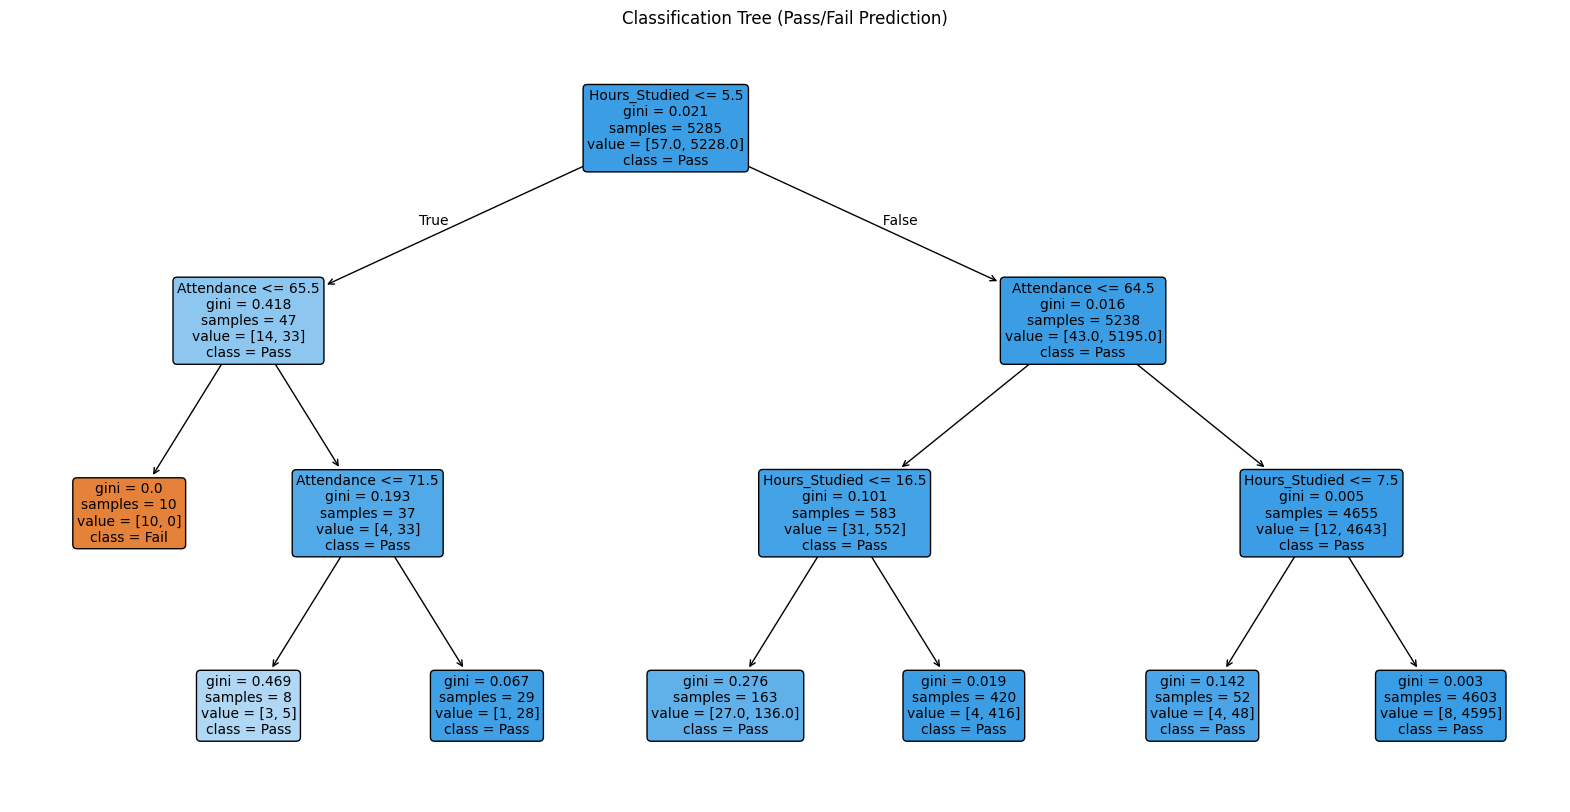

In [21]:
# plott the decision tree for classification
plt.figure(figsize=(20, 10))
plot_tree(
    clf, 
    feature_names=X_class.columns, 
    class_names=['Fail', 'Pass'] , 
    filled=True,
    rounded=True,
    fontsize=10)
plt.title('Classification Tree (Pass/Fail Prediction)')
plt.show()

1. Root Node Split
The first decision is made on Hours_Studied <= 5.5, meaning students who study very little are likely to be classified as Fail or need further evaluation.

2. Most Samples Classified as Pass
Almost all leaves end up classifying students as Pass, with very low Gini impurity → this indicates a very imbalanced dataset, likely with many more "Pass" labels.

3. Gini = 0.0 (Pure Leaf)
The orange node (class = Fail) has a Gini of 0.0, meaning it contains only Fail samples (perfect classification).

4. Strong Predictors:
The key features used in the splits are:
Hours_Studied  and Attendance

These are clearly the most informative for predicting outcome.

The decision tree shows that low study hours and low attendance are the strongest signals for failing.
Most branches lead to Pass, suggesting data imbalance.
The model is interpretable and highlights key thresholds (like Hours_Studied <= 5.5 and Attendance <= 65.5) that influence student outcomes.

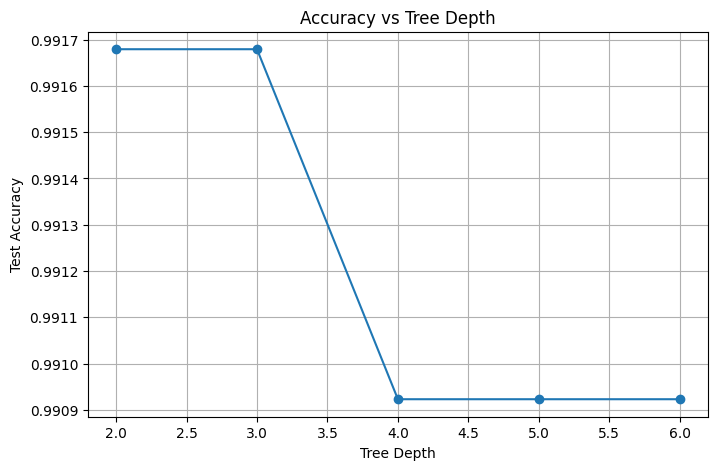

In [22]:
# plotting the dependence of accuracy and tree depths
depths = [2, 3, 4, 5, 6]
results = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(Xc_train, yc_train)
    acc = accuracy_score(yc_test, model.predict(Xc_test))
    results.append((depth, acc))

depth_df = pd.DataFrame(results, columns=['Max Depth', 'Test Accuracy'])

plt.figure(figsize=(8, 5))
plt.plot(depth_df['Max Depth'], depth_df['Test Accuracy'], marker='o')
plt.title('Accuracy vs Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

1. Highest Accuracy at Depth 2–3
The accuracy peaks at ~0.9917 when tree depth is 2 or 3, indicating an optimal balance of complexity and generalization.

2. Performance Drops After Depth 3
As the depth increases beyond 3, accuracy slightly decreases and then stabilizes at a lower level (~0.9909).
This suggests overfitting: the model starts to memorize the training data and performs worse on unseen data.

Conclusion:
Best tree depth = 2 or 3
These depths provide the best accuracy while keeping the model simple.
Going deeper adds complexity without performance gain and can hurt generalization.

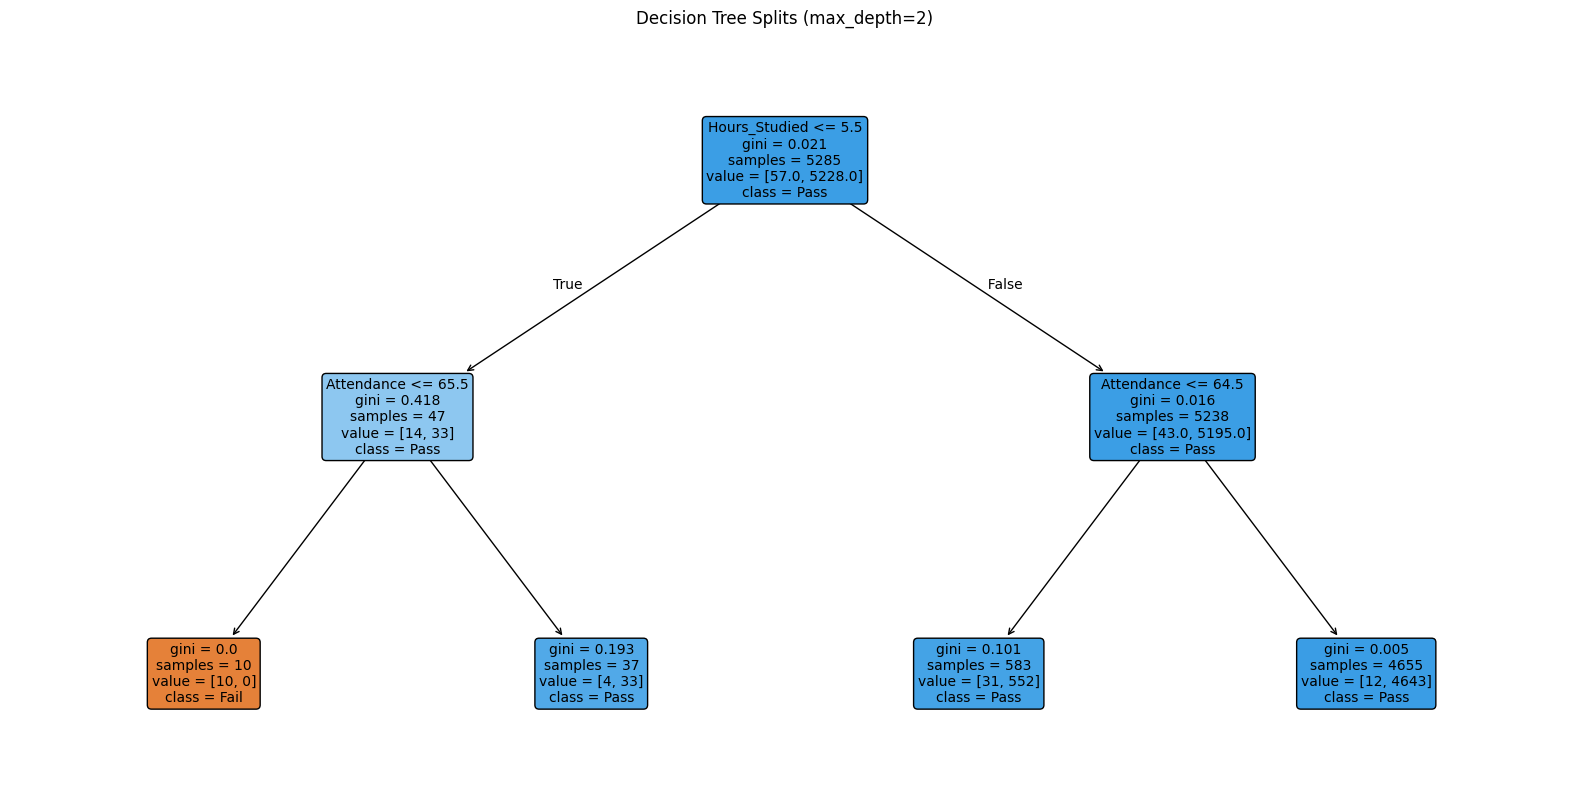

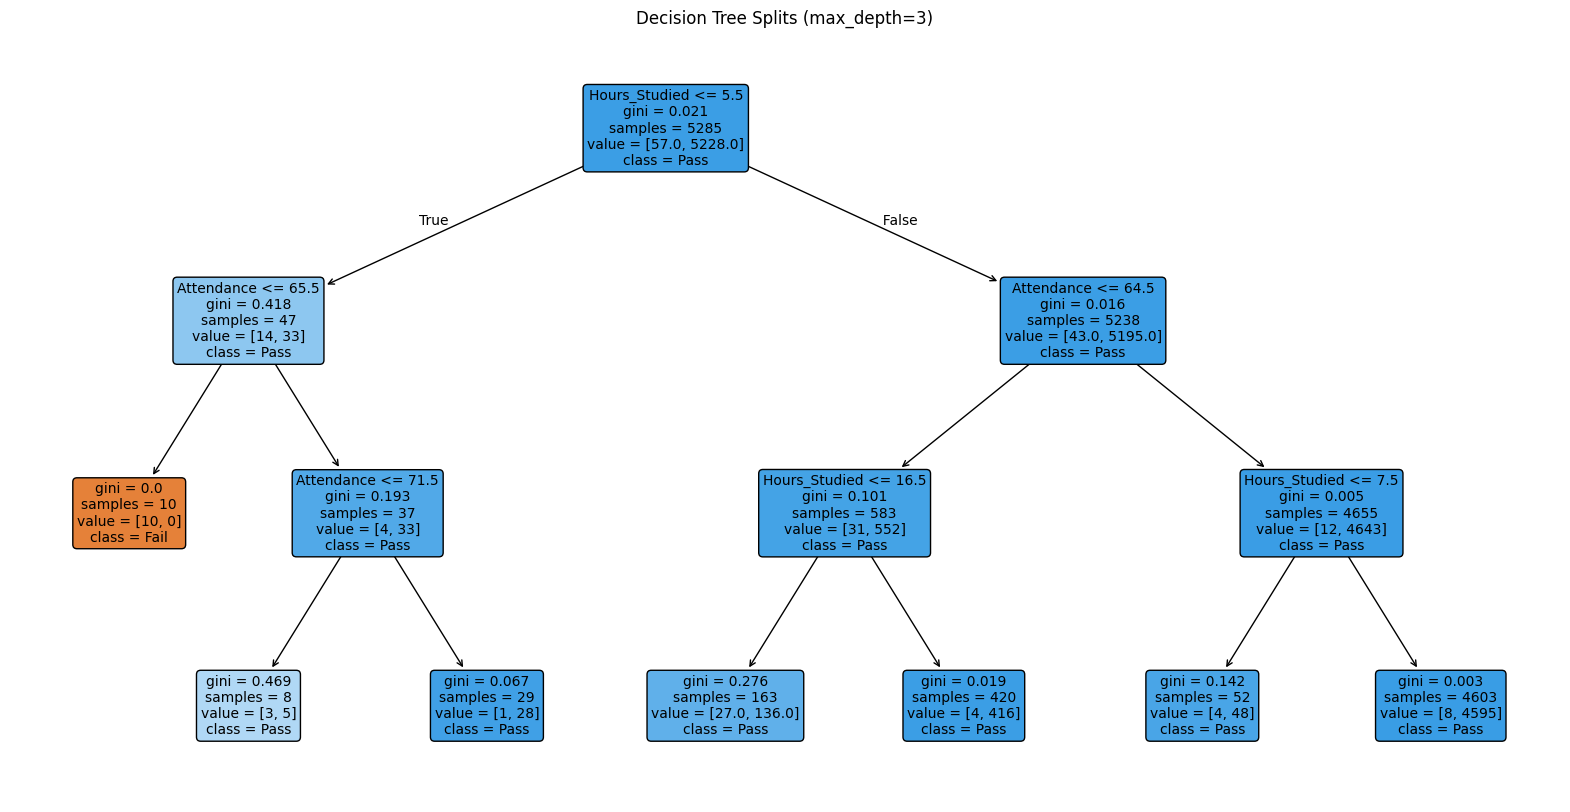

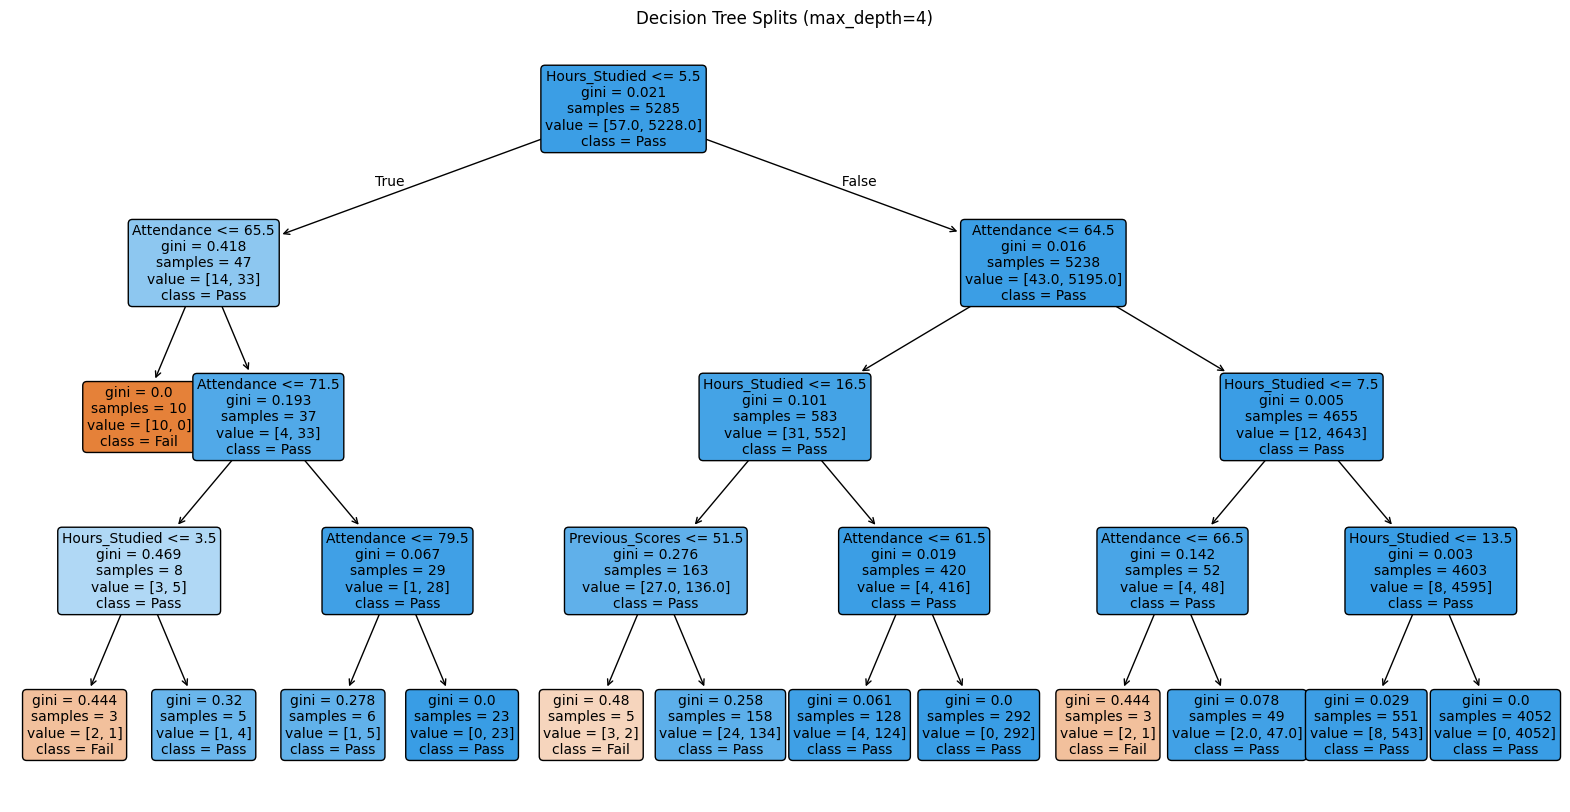

In [23]:
# plotting the decision tree for different depths
depths = [2, 3, 4]

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(Xc_train, yc_train)
    y_pred = model.predict(Xc_test)

    plt.figure(figsize=(20, 10))
    plot_tree(model, 
              feature_names=X.columns,
              class_names=model.classes_,
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(f'Decision Tree Splits (max_depth={depth})')
    plt.show()

# Random Forest

Mean Squared Error: 5.75
R² Score: 0.5933


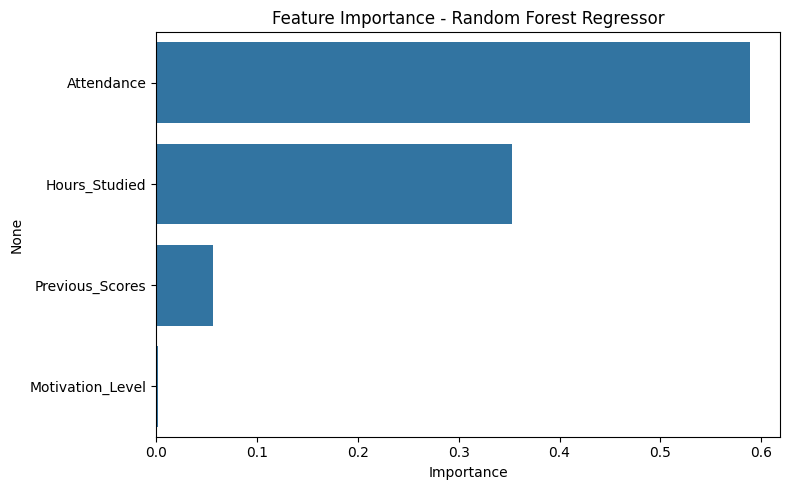

In [24]:
# load data
df = pd.read_csv('StudentPerformanceFactors.csv')

# label encoding categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[['Attendance', 'Hours_Studied', 'Previous_Scores', 'Motivation_Level']] # features variables
y = df['Exam_Score'] # target variable

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", round(mse, 2))
print("R² Score:", round(r2, 4))

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.title("Feature Importance - Random Forest Regressor")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

1. Attendance – most influential
Contributes more than 50% to the model’s predictions.
High attendance is strongly correlated with better performance.

2. Hours_Studied – second most important
Regular study hours are also key, but less critical than attendance.

3. Previous_Scores – moderate impact
Past academic success has some influence, though less predictive.

4. Motivation_Level – minimal impact
Surprisingly low influence in this model (possibly due to how it was measured).

Attendance is the strongest predictor of Exam_Score, followed by Hours_Studied.
Features like Motivation_Level may require better measurement or interaction terms to show value.

In [25]:
# define the parameters grid for tuning
n_estimators_range = [10, 50, 100, 200] # number of trees in the forest
max_features_options = [2, 4, 6, 8] # number of features to consider when looking for the best split

# initialize dictionaries to store errors
train_errors = {} # store training set of MSE 
test_errors = {} # store testing set MSE
oob_errors = {} # out-of-bag errors (1 - OOB R²)

# loop through different max_features and n_estimators
for max_feat in max_features_options:
    train_errors[max_feat] = []
    test_errors[max_feat] = []
    oob_errors[max_feat] = []
    
    ## for each number of estimators, train a Random Forest
    for n_estimators in n_estimators_range:
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   max_features=max_feat,
                                   oob_score=True,
                                   bootstrap=True,
                                   random_state=42)
        rf.fit(X_train, y_train) # train the model

        # predict on training and testing data
        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)

        # compute error metrics
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        oob_error = 1 - rf.oob_score_

        # store the results
        train_errors[max_feat].append(train_mse)
        test_errors[max_feat].append(test_mse)
        oob_errors[max_feat].append(oob_error)


c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\baha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


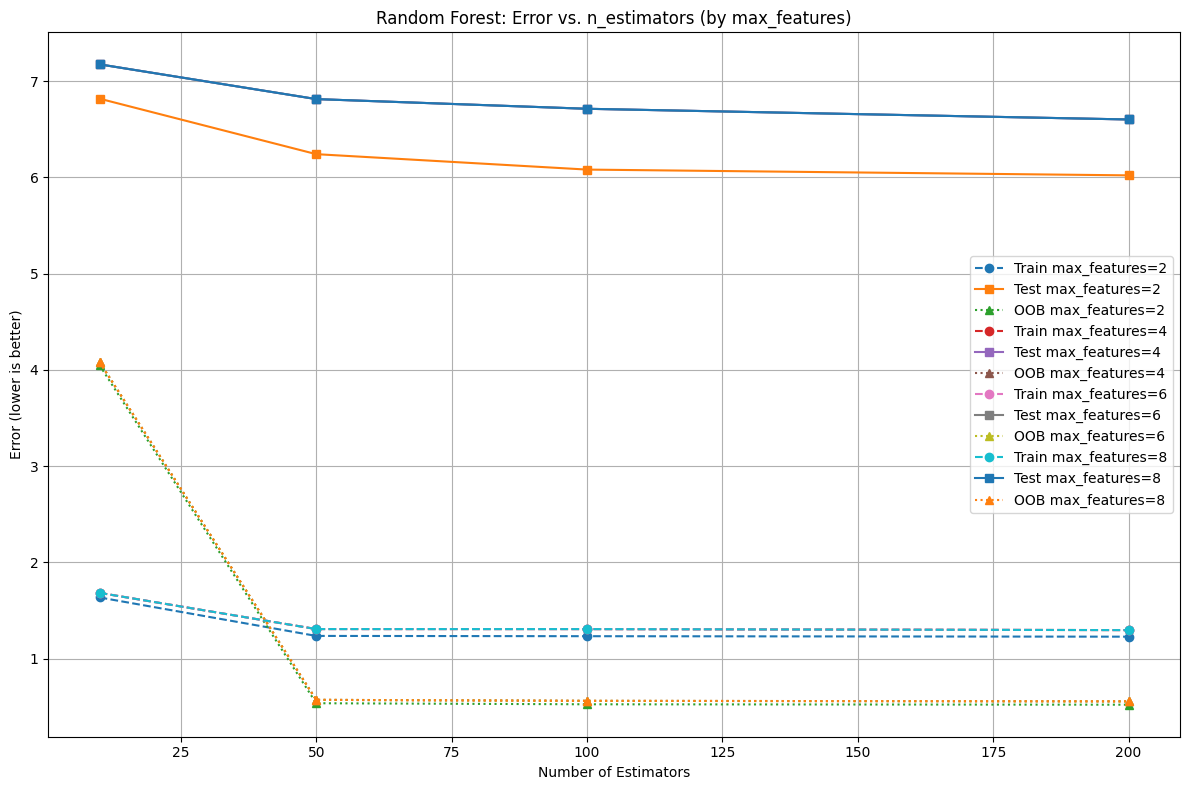

In [26]:
# plotting the errors
plt.figure(figsize=(12, 8))

# plot the errors for each max_features
for max_feat in max_features_options:
    plt.plot(n_estimators_range, train_errors[max_feat], label=f'Train max_features={max_feat}', linestyle='--', marker='o')
    plt.plot(n_estimators_range, test_errors[max_feat], label=f'Test max_features={max_feat}', linestyle='-', marker='s')
    plt.plot(n_estimators_range, oob_errors[max_feat], label=f'OOB max_features={max_feat}', linestyle=':', marker='^')

plt.xlabel("Number of Estimators")
plt.ylabel("Error (lower is better)")
plt.title("Random Forest: Error vs. n_estimators (by max_features)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1. More Trees = Lower Error
Error drops rapidly from 10-50 trees and flattens after ~100 trees, showing diminishing returns.

2. Higher max_features Performs Better
max_features=8 gives the lowest error across train, test, and OOB.
max_features=2 performs worst, especially on test data.

3. OOB ≈ Test Error
OOB error closely matches test error, making it a reliable validation method.

4. Train Error < Test/OOB (Expected)
Training error is lowest, but the gap is small — no clear overfitting observed.

The Random Forest model showed its best performance with max_features=8 and n_estimators=100–200.
Test and OOB errors aligned well, confirming the reliability of OOB validation.
Increasing the number of estimators beyond 100 gave minimal additional gain, suggesting this is an optimal range for model complexity and computation.

